# Stock prices prediction using AutoRegressive Integrated Moving Average (ARIMA) model 

### Mount GDrive and import the required libraries

In [47]:
# in case pmdarima cannot be imported
!pip install pmdarima

In [48]:
from google.colab import drive
import os
drive.mount('/content/drive')

# go to the correct forlder
%cd /content/drive/My\ Drive/Colab Notebooks/StockPricesPrediction
print('current working folder: ' + os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/StockPricesPrediction
current working folder: /content/drive/My Drive/Colab Notebooks/StockPricesPrediction


In [49]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from datetime import datetime

import tensorflow as tf
from function import check_stationary, model_performance
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

tf.test.gpu_device_name()

'/device:GPU:0'

### Configure GPU for Colab

In [50]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.2 GB  | Proc size: 1.1 GB
GPU RAM Free: 11307MB | Used: 134MB | Util   1% | Total 11441MB


### Load and plot of the dataset

In [52]:
# Load the data
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

data = pd.read_csv('AABA.csv', sep=",", parse_dates=['Date'], date_parser=dateparse)

# remove Nan and Inf values if present in the dataset
data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

print('The dataset has ' + str(len(data)) + ' records')
print('The dataset contains data from ' + data.iloc[0]['Date'].strftime("%d/%m/%Y") + ' to ' + data.iloc[-1]['Date'].strftime("%d/%m/%Y"))

The dataset has 5916 records
The dataset contains data from 12/04/1996 to 11/10/2019


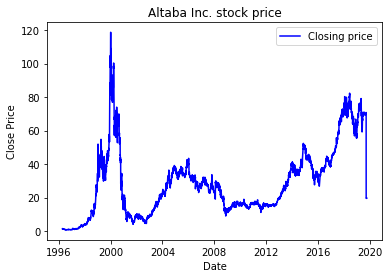

In [53]:
# Plot the data
plt.figure()
plt.plot(data['Date'],data['Close'], 'b', label='Closing price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Altaba Inc. stock price')
plt.legend()

### Check for degree of stationarity of the time series
**STATIONARY time series**: if they do not have trend or seasonal effect, i.e. if the statistical properties of the time series do not change over time.  Statistical modeling methods, in order to be effective, require the time series to be stationary.\

**AUGMENTED DICKEY-FULLER (ADF)** test is a type of statistical test called unit root test to test the stationarity of the time series.\
Interpretation of the ADF test results:\
p-value > 5% (1%) fail to reject the null hypothesis, the data has a unit root and is non-stationary\
p-value < 5% (1%) reject the null hypothesis, the data does not have a unit root and is stationary\
ADF statistic: the more negative the more likely we are to reject the null hypothesis (we have a stationary dataset)

**NOTE**: The ARIMA model converts non-stationary data to stationary data before working on it!!! The analysis conducted here is intended to give an overview how to check and make a time series stationary. 

ADF Statistic: -2.512930
p-value: 0.112360
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


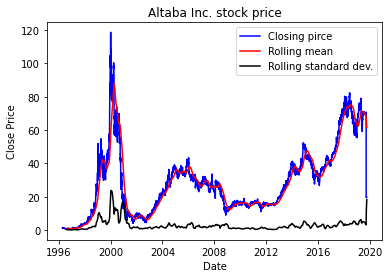

In [54]:
check_stationary(data['Close'], data['Date']) 

### Make time series stationary
Different strategies can be used to make a time series stationary. Here I consider two possible options:\
1) use the weighted rolling mean and subtract it from the original data, and\
2) differencing

1) **weighted rolling mean**

ADF Statistic: -4.110018
p-value: 0.000932
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


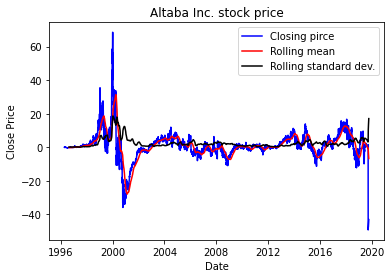

In [55]:
w_rolling_mean = data['Close'].ewm(alpha=0.01).mean()
data_stationary = data['Close'] - w_rolling_mean

# apply the ADT test to check the stationarity of the transformed time series
check_stationary(data_stationary, data['Date'])

2) **differencing**

ADF Statistic: -11.146713
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


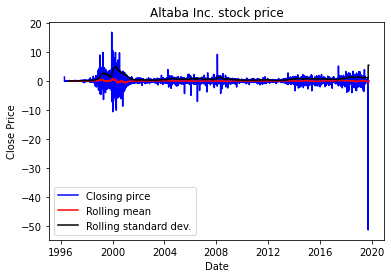

In [56]:
data_diff = data['Close'].diff().fillna(data['Close'])

# apply the ADT test to check the stationarity of the transformed time series
check_stationary(data_diff, data['Date'])

### Data pre-processing and train-test split

The train set corresponds to the 90.0% of the entire dataset
We will forecast the stock prices from 07/06/2017 till 11/10/2019


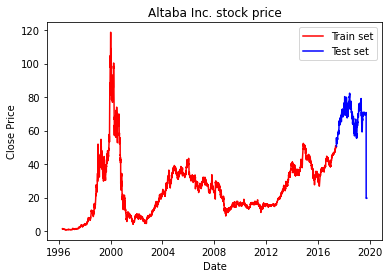

In [57]:
# We consider the log of the data series in order to reduce the rising trend of the series
X = np.log(data['Close']).to_numpy()

# train-test split
train_size = 0.9
size = int(len(X)*train_size)
train, test = X[0:size], X[size:len(X)]
train_date, test_date = data['Date'][0:size], data['Date'][size:len(X)]

plt.figure()
plt.plot(train_date, np.exp(train), 'r', label='Train set')
plt.plot(test_date, np.exp(test), 'b', label='Test set')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.title('Altaba Inc. stock price')
plt.legend() 

print('The train set corresponds to the ' + str(train_size*100) + '% of the entire dataset')
print('We will forecast the stock prices from ' + test_date.iloc[0].strftime("%d/%m/%Y") + ' till ' + test_date.iloc[-1].strftime("%d/%m/%Y"))

### ARIMA model
**ARIMA (AutoRegressive Integrated Moving Average)**\
We will use **auto_arima** to find the optimal order parameters (p, d and q) for an ARIMA model. Where:\
- p is the order of the AR model, i.e. the number of lag observations,
- d is the degree of differencing needed for stationarity, and,
- q is the number of lagged forecast errors in the prediction equation.

The auto_arima function seeks to identify the most optimal parameters for the ARIMA model in a grid search fashion. It works by conducting differencing test to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges.\
If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper-parameters to determine the optimal order of seasonal differencing, D.

In [ ]:
model = auto_arima(train, 
                   start_p=0, start_q=0,  # start valus of p and q
                   test='adf',            # use adftest to find optimal 'd'
                   max_p=5,   max_q=5,    # maximum p and q
                   m=1,                   # frequency of series
                   d=None,                # let model determine d
                   max_d = 3,             # max value of d
                   seasonal=False,        # No Seasonality
                   start_P=0, 
                   D=0, 
                   trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

print(model.summary())

### Build ARIMA model

**One step** forecast using the ARIMA model.\
The ARIMA model forecasts the next stock price value using the earlier price observations.\
In this case, the ARIMA prediction for the stock price at time (t+1) is not used to predict the stock price at time (t+2). Instead, the real stock price observation at time (t+1) is used.

In [58]:
history = [x for x in train]
prediction_one_step = list()
for t in range(len(test)): 
    arima_model = ARIMA(history, order=(3,1,0))
    model_fit = arima_model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    prediction_one_step.append(yhat)
    obs = test[t]
    # I append as next point the real observation of the stock price
    history.append(obs)

One step ARIMA model performance: 
MSE: 5.759892300394583
MAE: 0.9222282769328218
RMSE: 2.399977562477321
MAPE: 0.17596759629552636


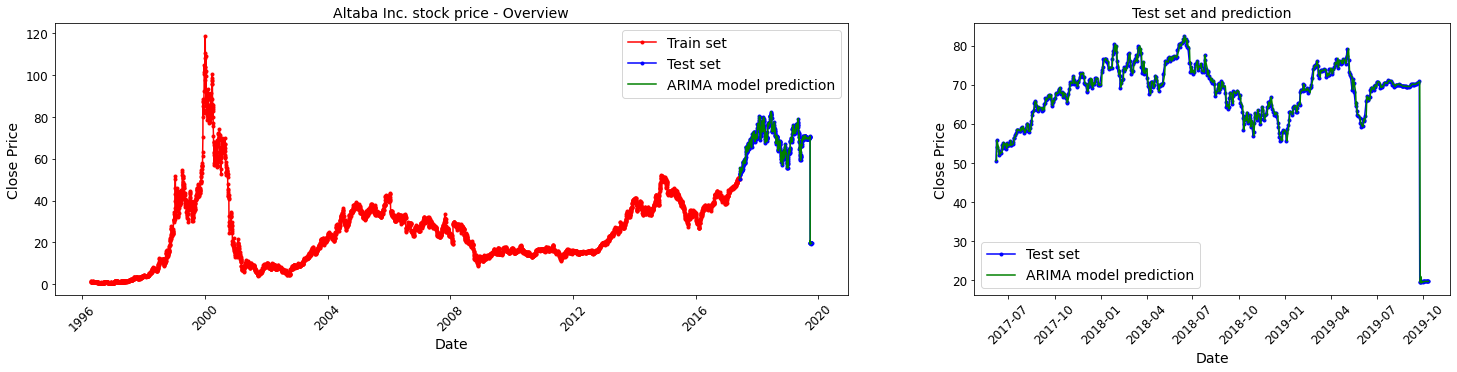

In [59]:
# plot the results
plt.figure(figsize=(25, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1.5]) 
ax0 = plt.subplot(gs[0])
plt.plot(train_date, np.exp(train), '.-r', label = 'Train set')
plt.plot(test_date, np.exp(test), '.-b', label = 'Test set')
plt.plot(test_date, np.exp(prediction_one_step), 'g', label = 'ARIMA model prediction')
plt.ylabel('Close Price', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Altaba Inc. stock price - Overview', fontsize=14)
plt.legend(fontsize=14)
ax0 = plt.subplot(gs[1])
plt.plot(test_date, np.exp(test), '.-b', label = 'Test set')
plt.plot(test_date, np.exp(prediction_one_step), 'g', label = 'ARIMA model prediction')
plt.ylabel('Close Price', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Test set and prediction', fontsize=14)
plt.legend(fontsize=14)

print('One step ARIMA model performance: ')
model_performance(np.exp(test), np.exp(prediction_one_step))

**Multi step** forecast using the ARIMA model.\
The real challange is not to predict only one stock price ahead but multiple stock prices in the future.\
In this case, the ARIMA prediction for the stock price at time (t+1) is used to predict the stock price at time (t+2).

In [ ]:
history = [x for x in train]
prediction_multi_step = list()
for t in range(len(test)): 
    arima_model = ARIMA(history, order=(3,1,0))
    model_fit = arima_model.fit(disp=0)
    output = model_fit.forecast(1, alpha=0.05)
    yhat = output[0]
    prediction_multi_step.append(yhat)
    obs = test[t]
    # NOTE: I append as next point the prediction made by the ARIMA model
    history.append(yhat)

In [ ]:
# plot the results
plt.figure(figsize=(25, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1.5]) 
ax0 = plt.subplot(gs[0])
plt.plot(train_date, np.exp(train), '.-r', label = 'Train set')
plt.plot(test_date, np.exp(test), '.-b', label = 'Test set')
plt.plot(test_date, np.exp(prediction_multi_step), 'g', label = 'ARIMA model prediction')
plt.ylabel('Close Price', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Altaba Inc. stock price - Overview', fontsize=14)
plt.legend(fontsize=14)
ax0 = plt.subplot(gs[1])
plt.plot(test_date, np.exp(test), '.-b', label = 'Test set')
plt.plot(test_date, np.exp(prediction_multi_step), 'g', label = 'ARIMA model prediction')
plt.ylabel('Close Price', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Test set and prediction', fontsize=14)
plt.legend(fontsize=14)

print('Multi step ARIMA model performance: ')
model_performance(np.exp(test), np.exp(prediction_multi_step))